# Tutorial for Chinese Sentiment analysis with hotel review data
## Dependencies

Python 3.5, numpy, pickle, keras, tensorflow, [jieba](https://github.com/fxsjy/jieba)

## Optional for plotting

pylab, scipy


In [2]:
from os import listdir
from os.path import isfile, join
import jieba
import codecs
from profitero_data_scientist.chinese_sentiment_analysis_master.langconv import *  # convert Traditional Chinese characters to Simplified Chinese characters
import pickle
import random

from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.preprocessing.text import Tokenizer
from keras.layers.core import Dense
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard


## Helper function to pickle and load stuff

In [3]:
def __pickleStuff(filename, stuff):
    save_stuff = open(filename, "wb")
    pickle.dump(stuff, save_stuff)
    save_stuff.close()
def __loadStuff(filename):
    saved_stuff = open(filename, "rb")
    stuff = pickle.load(saved_stuff)
    saved_stuff.close()
    return stuff


## Get lists of files, positive and negative files

In [4]:
dataBaseDirPos = "./profitero_data_scientist/chinese_sentiment_analysis_master/data/ChnSentiCorp_htl_ba_6000/pos/"
dataBaseDirNeg = "./profitero_data_scientist/chinese_sentiment_analysis_master/data/ChnSentiCorp_htl_ba_6000/neg/"
positiveFiles = [dataBaseDirPos + f for f in listdir(dataBaseDirPos) if isfile(join(dataBaseDirPos, f))]
negativeFiles = [dataBaseDirNeg + f for f in listdir(dataBaseDirNeg) if isfile(join(dataBaseDirNeg, f))]

## Show length of samples

In [5]:
print(len(positiveFiles))
print(len(negativeFiles))

2916
3000


## Have a look at what's in a file(one hotel review)

In [6]:
filename = positiveFiles[0]
with codecs.open(filename, "rb") as doc_file:
    text = doc_file.read()
    text = text.decode("GB2312")
    text = text.replace("\n", "")
    text = text.replace("\r", "")
print("==Orginal==:\n\r{}".format(text))
print(text)

==Orginal==:
原先看了别人的评价，做好了不怎么样的准备，到了之后真的有惊喜的感觉，在富豪酒店住了3天，（我们也是住在三楼，）房间虽然不是很大，但也够住了，房间是新装修的，很不错，也蛮有情调的，四面都是镜子，感觉不错，服务人员的态度也还是不错的，第一天到酒店时，忘了行李，酒店还专门打电话询问呢，一个老先生还帮我们收好了行李，CHECK-IN 的速度也很快的，也没有什么说普通话被歧视的感觉，交通离地铁远了些，但周围公交和小巴很方便，我们一共去了五个人，所以打车去地铁站比做小巴和公交合算，周围的又一城和新城都是购物的好去处，附近的小吃，茶餐厅，甜品店很多的，一家叫口香舌滑的甜品店里的榴莲飘飘很不错的，总的来说，这家酒店的性价比还是很不错的，以后还会去的，另外在酒店还可以定去迪士尼的直达车，也很方便的。周围环境不是很现代，但也没什么影响。
原先看了别人的评价，做好了不怎么样的准备，到了之后真的有惊喜的感觉，在富豪酒店住了3天，（我们也是住在三楼，）房间虽然不是很大，但也够住了，房间是新装修的，很不错，也蛮有情调的，四面都是镜子，感觉不错，服务人员的态度也还是不错的，第一天到酒店时，忘了行李，酒店还专门打电话询问呢，一个老先生还帮我们收好了行李，CHECK-IN 的速度也很快的，也没有什么说普通话被歧视的感觉，交通离地铁远了些，但周围公交和小巴很方便，我们一共去了五个人，所以打车去地铁站比做小巴和公交合算，周围的又一城和新城都是购物的好去处，附近的小吃，茶餐厅，甜品店很多的，一家叫口香舌滑的甜品店里的榴莲飘飘很不错的，总的来说，这家酒店的性价比还是很不错的，以后还会去的，另外在酒店还可以定去迪士尼的直达车，也很方便的。周围环境不是很现代，但也没什么影响。


## Test removing stop words
Demo what it looks like to tokenize the sentence and remove stop words.

In [8]:
filename = positiveFiles[110]
with codecs.open(filename, "rb") as doc_file:
    text = doc_file.read()
    text = text.decode("GB2312")
    text = text.replace("\n", "")
    text = text.replace("\r", "")
print("==Orginal==:\n\r{}".format(text))

stopwords = [line.rstrip() for line in
             codecs.open('./profitero_data_scientist/chinese_sentiment_analysis_master/data/chinese_stop_words.txt',
                         "r", encoding="utf-8")]
seg_list = jieba.cut(text, cut_all=False)
final = []
seg_list = list(seg_list)
for seg in seg_list:
    if seg not in stopwords:
        final.append(seg)
print("==Tokenized==\tToken count:{}\n\r{}".format(len(seg_list), " ".join(seg_list)))
print("==Stop Words Removed==\tToken count:{}\n\r{}".format(len(final), " ".join(final)))


==Orginal==:
外环境不错,酒店有好几栋楼，挺赏心悦目的，大厅挺安静，布置也很有点小资情调，可能是黄金周刚结束的缘故吧。我住的是主楼２４０元的房间，四星级这个价格在国内应该很值了。早餐是自助的，以中式为主，品种挺多，挺适合咱中国人的胃。结账时才知道还有更经济的附楼（好像叫展鸿楼）的房间只要一百多元，不过未挂星。（大门还在改造）下次去试试。值的推荐呀……补充点评 2007年10月10日 ： 对了，还有免费水果，很温馨的感觉，宽带速度也很快。
==Tokenized==	Token count:142
外 环境 不错 , 酒店 有 好 几栋 楼 ， 挺 赏心悦目 的 ， 大厅 挺 安静 ， 布置 也 很 有点 小资 情调 ， 可能 是 黄金周 刚 结束 的 缘故 吧 。 我 住 的 是 主楼 ２ ４ ０ 元 的 房间 ， 四星级 这个 价格 在 国内 应该 很值 了 。 早餐 是 自助 的 ， 以 中式 为主 ， 品种 挺 多 ， 挺 适合 咱 中国 人 的 胃 。 结账 时才 知道 还有 更 经济 的 附楼 （ 好像 叫 展鸿楼 ） 的 房间 只要 一百多元 ， 不过 未挂星 。 （ 大门 还 在 改造 ） 下次 去 试试 。 值 的 推荐 呀 … … 补充 点评   2007 年 10 月 10 日   ：   对 了 ， 还有 免费 水果 ， 很 温馨 的 感觉 ， 宽带 速度 也 很快 。
==Stop Words Removed==	Token count:67
外 环境 不错 酒店 几栋 楼 挺 赏心悦目 大厅 挺 安静 布置 小资 情调 黄金周 结束 缘故 住 主楼 元 房间 四星级 价格 国内 很值 早餐 自助 中式 品种 挺 挺 适合 中国 胃 结账 时才 经济 附楼 好像 展鸿楼 房间 一百多元 未挂星 大门 改造 下次 试试 值 推荐 补充 点评   2007 年 10 月 10 日     免费 水果 温馨 感觉 宽带 速度 很快


## Prepare "doucments", a list of tuples
Some files contain abnormal encoding characters which encoding GB2312 will complain about. Solution: read as bytes then decode as GB2312 line by line, skip lines with abnormal encodings. We also convert any traditional Chinese characters to simplified Chinese characters.

In [10]:
documents = []
for filename in positiveFiles:
    text = ""
    with codecs.open(filename, "rb") as doc_file:
        for line in doc_file:
            try:
                line = line.decode("GB2312")
            except:
                continue
            text+=Converter('zh-hans').convert(line)# Convert from traditional to simplified Chinese

            text = text.replace("\n", "")
            text = text.replace("\r", "")
    documents.append((text, "pos"))

for filename in negativeFiles:
    text = ""
    with codecs.open(filename, "rb") as doc_file:
        for line in doc_file:
            try:
                line = line.decode("GB2312")
            except:
                continue
            text+=Converter('zh-hans').convert(line)# Convert from traditional to simplified Chinese

            text = text.replace("\n", "")
            text = text.replace("\r", "")
    documents.append((text, "neg"))


## Optional step to save/load the documents as pickle file

In [10]:
# Uncomment those two lines to save/load the documents for later use since the step above takes a while
# __pickleStuff("./data/chinese_sentiment_corpus.p", documents)
# documents = __loadStuff("./data/chinese_sentiment_corpus.p")
print(len(documents))
print(documents[4000])

5916
('', 'neg')


## shuffle the data

In [12]:
random.shuffle(documents)

## Prepare the input and output for the model
Each input (hotel review) will be a list of tokens, output will be one token("pos" or "neg"). The stopwords are not removed here since the dataset is relative small and removing the stop words are not saving much traing time.

In [13]:
# Tokenize only
totalX = []
totalY = [str(doc[1]) for doc in documents]
for doc in documents:
    seg_list = jieba.cut(doc[0], cut_all=False)
    seg_list = list(seg_list)
    totalX.append(seg_list)

print(totalX[0])

#Switch to below code to experiment with removing stop words
# Tokenize and remove stop words
# totalX = []
# totalY = [str(doc[1]) for doc in documents]
# stopwords = [ line.rstrip() for line in codecs.open('./data/chinese_stop_words.txt',"r", encoding="utf-8") ]
# for doc in documents:
#     seg_list = jieba.cut(doc[0], cut_all=False)
#     seg_list = list(seg_list)
#     Uncomment below code to experiment with removing stop words
#     final =[]
#     for seg in seg_list:
#         if seg not in stopwords:
#             final.append(seg)
#     totalX.append(final)


['空气', '好', '是', '没有话说', '的', '。', '鱼疗', '减少', '了', '很多', '的', '死', '皮', '。', '温泉', '的确', '是', '室外', '的', '好', '（', '虽然', '不是', '很深', '，', '人', '是', '不能', '站', '起来', '的', '）', '，', '但是', '服务', '上要', '加强', '的', '地方', '太多', '了', '。', '第一', '，', '早餐', '9', '：', '30', '要', '结束', '，', '我', '大约', '9', '：', '25', '左右', '到', '餐厅', '，', '餐厅', '的', '迎宾', '没有', '事先', '告知', '，', '进去', '后', '，', '早餐', '已经', '收', '得', '差不多', '了', '，', '从', '服务员', '手里', '抢', '了', '一', '大盘', '米粉', '，', '基本', '没有', '吃', '到', '什么', '。', '第二', '，', '2', '楼', '的', '房间', '都', '没有', '保险箱', '，', '就', '差', '这', '一个', '楼层', '么', '？', '第三', '，', '中餐厅', '的', '服务员', '没有', '事', '的', '时候', '就', '聚', '在', '巴台', '聊天', '，', '服务', '基本', '靠', '自助', '。', '第四', '，', '温泉', '的', '服务', '也', '不是', '很', '好', '，', '我们', '一起', '去', '了', '三个', '人', '，', '要', '做', '足疗', '，', '我们', '在', '等', '服务员', '的', '时候', '，', '一', '起来', '的', '一个', '人', '跑', '开', '了', '，', '因为', '他', '不', '清楚', '另外', '一个', '人', '请', '他', '做', '足疗', '，', '服务员', '来', '了', '后', '，

## Visualize distribution of sentence length
Decide the max input sequence, here we cover up to 60% sentences. The longer input sequence, the more training time will take, but could improve  prediction accuracy.

Max length is:  1804
60% cover length up to:  68


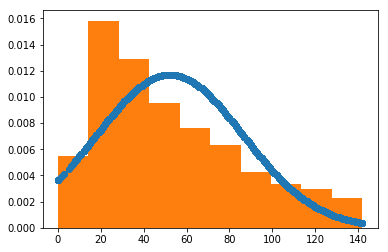

Max length is:  1804
60% cover length up to:  68


Max length is:  1804
60% cover length up to:  68


In [14]:
import numpy as np
import scipy.stats as stats
import pylab as pl

h = sorted([len(sentence) for sentence in totalX])
maxLength = h[int(len(h) * 0.60)]
print("Max length is: ", h[len(h) - 1])
print("60% cover length up to: ", maxLength)
h = h[:5000]
fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h, fit, '-o')
pl.hist(h, normed=True)  #use this to draw histogram of your data
pl.show()


## Words to number tokens, padding
Pad input sequence to max input length if it is shorter


Save the input tokenizer, since we need to use the same tokenizer for our new predition data.

In [15]:
totalX = [" ".join(wordslist) for wordslist in
          totalX]  # Keras Tokenizer expect the words tokens to be seperated by space 
input_tokenizer = Tokenizer(30000)  # Initial vocab size
input_tokenizer.fit_on_texts(totalX)
vocab_size = len(input_tokenizer.word_index) + 1
print("input vocab_size:", vocab_size)
totalX = np.array(pad_sequences(input_tokenizer.texts_to_sequences(totalX), maxlen=maxLength))
__pickleStuff("./profitero_data_scientist/chinese_sentiment_analysis_master/data/input_tokenizer_chinese.p",
              input_tokenizer)


input vocab_size: 22123


## Output, array of 0s and 1s

In [16]:
target_tokenizer = Tokenizer(3)
target_tokenizer.fit_on_texts(totalY)
print("output vocab_size:",len(target_tokenizer.word_index) + 1)
totalY = np.array(target_tokenizer.texts_to_sequences(totalY)) -1
totalY = totalY.reshape(totalY.shape[0])

output vocab_size: 3


In [17]:
totalY[40:50]

array([0, 1, 1, 1, 1, 0, 0, 1, 1, 0])

## Turn output 0s and 1s to categories(one-hot vectors)

In [18]:
totalY = to_categorical(totalY, num_classes=2)

In [19]:
totalY[40:50]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.]])

In [20]:
output_dimen = totalY.shape[1] # which is 2

## Save meta data for later predition
maxLength: the input sequence length

vocab_size: Input vocab size

output_dimen: which is 2 in this example (pos or neg)

sentiment_tag: either ["neg","pos"] or ["pos","neg"] matching the target tokenizer

In [21]:
target_reverse_word_index = {v: k for k, v in list(target_tokenizer.word_index.items())}
sentiment_tag = [target_reverse_word_index[1], target_reverse_word_index[2]]
metaData = {"maxLength": maxLength, "vocab_size": vocab_size, "output_dimen": output_dimen,
            "sentiment_tag": sentiment_tag}
__pickleStuff("./profitero_data_scientist/chinese_sentiment_analysis_master/data/meta_sentiment_chinese.p", metaData)


## Build the Model, train and save it
The training data is logged to Tensorboard, we can look at it by cd into directory 

"./Graph/sentiment_chinese" and run


"python -m tensorflow.tensorboard --logdir=."

In [21]:
embedding_dim = 256

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim,input_length = maxLength))
# Each input would have a size of (maxLength x 256) and each of these 256 sized vectors are fed into the GRU layer one at a time.
# All the intermediate outputs are collected and then passed on to the second GRU layer.
model.add(GRU(256, dropout=0.9, return_sequences=True))
# Using the intermediate outputs, we pass them to another GRU layer and collect the final output only this time
model.add(GRU(256, dropout=0.9))
# The output is then sent to a fully connected layer that would give us our final output_dim classes
model.add(Dense(output_dimen, activation='softmax'))
# We use the adam optimizer instead of standard SGD since it converges much faster
tbCallBack = TensorBoard(log_dir='./Graph/sentiment_chinese', histogram_freq=0,
                            write_graph=True, write_images=True)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
model.fit(totalX, totalY, validation_split=0.1, batch_size=32, epochs=1, verbose=1, callbacks=[tbCallBack])
model.save('./profitero_data_scientist/chinese_sentiment_analysis_master/data/sentiment_chinese_model.hdf5')

print("Saved model!")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 68, 256)           5663488   
_________________________________________________________________
gru_1 (GRU)                  (None, 68, 256)           393984    
_________________________________________________________________
gru_2 (GRU)                  (None, 256)               393984    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 6,451,970
Trainable params: 6,451,970
Non-trainable params: 0
_________________________________________________________________


Train on 5324 samples, validate on 592 samples


Epoch 1/1


  32/5324 [..............................] - ETA: 2:33 - loss: 0.6956 - acc: 0.4688

  64/5324 [..............................] - ETA: 2:02 - loss: 0.7005 - acc: 0.4531

  96/5324 [..............................] - ETA: 1:52 - loss: 0.7064 - acc: 0.4375

 128/5324 [..............................] - ETA: 1:47 - loss: 0.6997 - acc: 0.4609

 160/5324 [..............................] - ETA: 1:44 - loss: 0.6957 - acc: 0.4750

 192/5324 [>.............................] - ETA: 1:42 - loss: 0.6935 - acc: 0.4948

 224/5324 [>.............................] - ETA: 1:40 - loss: 0.6966 - acc: 0.4911

 256/5324 [>.............................] - ETA: 1:38 - loss: 0.6954 - acc: 0.4922

 288/5324 [>.............................] - ETA: 1:36 - loss: 0.6917 - acc: 0.5000

 320/5324 [>.............................] - ETA: 1:35 - loss: 0.6940 - acc: 0.5031

 352/5324 [>.............................] - ETA: 1:33 - loss: 0.6966 - acc: 0.4972

 384/5324 [=>............................] - ETA: 1:32 - loss: 0.7017 - acc: 0.4844

 416/5324 [=>............................] - ETA: 1:31 - loss: 0.7027 - acc: 0.4808

 448/5324 [=>............................] - ETA: 1:31 - loss: 0.7032 - acc: 0.4799

 480/5324 [=>............................] - ETA: 1:30 - loss: 0.7012 - acc: 0.4896

 512/5324 [=>............................] - ETA: 1:29 - loss: 0.7003 - acc: 0.4902

 544/5324 [==>...........................] - ETA: 1:28 - loss: 0.7001 - acc: 0.4926

 576/5324 [==>...........................] - ETA: 1:28 - loss: 0.6975 - acc: 0.4983

 608/5324 [==>...........................] - ETA: 1:27 - loss: 0.6993 - acc: 0.4951

 640/5324 [==>...........................] - ETA: 1:26 - loss: 0.7003 - acc: 0.4906

 672/5324 [==>...........................] - ETA: 1:25 - loss: 0.6995 - acc: 0.4911

 704/5324 [==>...........................] - ETA: 1:25 - loss: 0.7008 - acc: 0.4886

 736/5324 [===>..........................] - ETA: 1:24 - loss: 0.7017 - acc: 0.4864

 768/5324 [===>..........................] - ETA: 1:23 - loss: 0.7007 - acc: 0.4896

 800/5324 [===>..........................] - ETA: 1:23 - loss: 0.7017 - acc: 0.4925

 832/5324 [===>..........................] - ETA: 1:22 - loss: 0.7008 - acc: 0.4952

 864/5324 [===>..........................] - ETA: 1:21 - loss: 0.7006 - acc: 0.4988

 896/5324 [====>.........................] - ETA: 1:21 - loss: 0.7017 - acc: 0.4978

 928/5324 [====>.........................] - ETA: 1:20 - loss: 0.7005 - acc: 0.4989

 960/5324 [====>.........................] - ETA: 1:19 - loss: 0.7016 - acc: 0.4969

 992/5324 [====>.........................] - ETA: 1:18 - loss: 0.7023 - acc: 0.4929

1024/5324 [====>.........................] - ETA: 1:18 - loss: 0.7024 - acc: 0.4932

1056/5324 [====>.........................] - ETA: 1:17 - loss: 0.7024 - acc: 0.4934

1088/5324 [=====>........................] - ETA: 1:16 - loss: 0.7013 - acc: 0.4991

1120/5324 [=====>........................] - ETA: 1:16 - loss: 0.7012 - acc: 0.5009

1152/5324 [=====>........................] - ETA: 1:15 - loss: 0.7005 - acc: 0.5035

1184/5324 [=====>........................] - ETA: 1:14 - loss: 0.7014 - acc: 0.4992

1216/5324 [=====>........................] - ETA: 1:14 - loss: 0.6999 - acc: 0.5041

1248/5324 [======>.......................] - ETA: 1:13 - loss: 0.6995 - acc: 0.5048

1280/5324 [======>.......................] - ETA: 1:12 - loss: 0.6996 - acc: 0.5047

1312/5324 [======>.......................] - ETA: 1:12 - loss: 0.6994 - acc: 0.5053

1344/5324 [======>.......................] - ETA: 1:11 - loss: 0.6981 - acc: 0.5074

1376/5324 [======>.......................] - ETA: 1:11 - loss: 0.6996 - acc: 0.5051

1408/5324 [======>.......................] - ETA: 1:10 - loss: 0.6999 - acc: 0.5057

1440/5324 [=======>......................] - ETA: 1:09 - loss: 0.6999 - acc: 0.5076

1472/5324 [=======>......................] - ETA: 1:09 - loss: 0.6996 - acc: 0.5075

1504/5324 [=======>......................] - ETA: 1:08 - loss: 0.6990 - acc: 0.5100

1536/5324 [=======>......................] - ETA: 1:08 - loss: 0.6990 - acc: 0.5091

1568/5324 [=======>......................] - ETA: 1:07 - loss: 0.7004 - acc: 0.5070

1600/5324 [========>.....................] - ETA: 1:07 - loss: 0.7009 - acc: 0.5056

1632/5324 [========>.....................] - ETA: 1:06 - loss: 0.7001 - acc: 0.5074

1664/5324 [========>.....................] - ETA: 1:05 - loss: 0.7001 - acc: 0.5078

1696/5324 [========>.....................] - ETA: 1:05 - loss: 0.6996 - acc: 0.5094

1728/5324 [========>.....................] - ETA: 1:04 - loss: 0.6997 - acc: 0.5104

1760/5324 [========>.....................] - ETA: 1:04 - loss: 0.6995 - acc: 0.5119

1792/5324 [=========>....................] - ETA: 1:03 - loss: 0.6993 - acc: 0.5123

1824/5324 [=========>....................] - ETA: 1:02 - loss: 0.7000 - acc: 0.5143

1856/5324 [=========>....................] - ETA: 1:02 - loss: 0.7000 - acc: 0.5135

1888/5324 [=========>....................] - ETA: 1:01 - loss: 0.6999 - acc: 0.5148

1920/5324 [=========>....................] - ETA: 1:01 - loss: 0.6990 - acc: 0.5161

1952/5324 [=========>....................] - ETA: 1:00 - loss: 0.6995 - acc: 0.5143

1984/5324 [==========>...................] - ETA: 59s - loss: 0.6989 - acc: 0.5161 

2016/5324 [==========>...................] - ETA: 59s - loss: 0.6991 - acc: 0.5169

2048/5324 [==========>...................] - ETA: 58s - loss: 0.6984 - acc: 0.5176

2080/5324 [==========>...................] - ETA: 58s - loss: 0.6984 - acc: 0.5192

2112/5324 [==========>...................] - ETA: 57s - loss: 0.6986 - acc: 0.5194

2144/5324 [===========>..................] - ETA: 56s - loss: 0.6983 - acc: 0.5187

2176/5324 [===========>..................] - ETA: 56s - loss: 0.6975 - acc: 0.5207

2208/5324 [===========>..................] - ETA: 55s - loss: 0.6973 - acc: 0.5213

2240/5324 [===========>..................] - ETA: 55s - loss: 0.6970 - acc: 0.5219

2272/5324 [===========>..................] - ETA: 54s - loss: 0.6968 - acc: 0.5233

2304/5324 [===========>..................] - ETA: 53s - loss: 0.6970 - acc: 0.5234

2336/5324 [============>.................] - ETA: 53s - loss: 0.6965 - acc: 0.5240

2368/5324 [============>.................] - ETA: 52s - loss: 0.6968 - acc: 0.5236

2400/5324 [============>.................] - ETA: 52s - loss: 0.6967 - acc: 0.5250

2432/5324 [============>.................] - ETA: 51s - loss: 0.6968 - acc: 0.5263

2464/5324 [============>.................] - ETA: 51s - loss: 0.6971 - acc: 0.5248

2496/5324 [=============>................] - ETA: 50s - loss: 0.6965 - acc: 0.5260

2528/5324 [=============>................] - ETA: 49s - loss: 0.6960 - acc: 0.5273

2560/5324 [=============>................] - ETA: 49s - loss: 0.6955 - acc: 0.5285

2592/5324 [=============>................] - ETA: 48s - loss: 0.6952 - acc: 0.5285

2624/5324 [=============>................] - ETA: 48s - loss: 0.6955 - acc: 0.5286

2656/5324 [=============>................] - ETA: 47s - loss: 0.6953 - acc: 0.5286

2688/5324 [==============>...............] - ETA: 47s - loss: 0.6955 - acc: 0.5309

2720/5324 [==============>...............] - ETA: 46s - loss: 0.6957 - acc: 0.5309

2752/5324 [==============>...............] - ETA: 45s - loss: 0.6953 - acc: 0.5320

2784/5324 [==============>...............] - ETA: 45s - loss: 0.6949 - acc: 0.5316

2816/5324 [==============>...............] - ETA: 44s - loss: 0.6940 - acc: 0.5341

2848/5324 [===============>..............] - ETA: 44s - loss: 0.6939 - acc: 0.5351

2880/5324 [===============>..............] - ETA: 43s - loss: 0.6936 - acc: 0.5365

2912/5324 [===============>..............] - ETA: 43s - loss: 0.6939 - acc: 0.5347

2944/5324 [===============>..............] - ETA: 42s - loss: 0.6937 - acc: 0.5357

2976/5324 [===============>..............] - ETA: 41s - loss: 0.6932 - acc: 0.5366

3008/5324 [===============>..............] - ETA: 41s - loss: 0.6929 - acc: 0.5382

3040/5324 [================>.............] - ETA: 40s - loss: 0.6924 - acc: 0.5385

3072/5324 [================>.............] - ETA: 40s - loss: 0.6925 - acc: 0.5381

3104/5324 [================>.............] - ETA: 39s - loss: 0.6917 - acc: 0.5396

3136/5324 [================>.............] - ETA: 38s - loss: 0.6906 - acc: 0.5415

3168/5324 [================>.............] - ETA: 38s - loss: 0.6906 - acc: 0.5410

3200/5324 [=================>............] - ETA: 37s - loss: 0.6910 - acc: 0.5416

3232/5324 [=================>............] - ETA: 37s - loss: 0.6907 - acc: 0.5418

3264/5324 [=================>............] - ETA: 36s - loss: 0.6900 - acc: 0.5423

3296/5324 [=================>............] - ETA: 36s - loss: 0.6891 - acc: 0.5443

3328/5324 [=================>............] - ETA: 35s - loss: 0.6876 - acc: 0.5466

3360/5324 [=================>............] - ETA: 34s - loss: 0.6869 - acc: 0.5485

3392/5324 [==================>...........] - ETA: 34s - loss: 0.6865 - acc: 0.5495

3424/5324 [==================>...........] - ETA: 33s - loss: 0.6843 - acc: 0.5520

3456/5324 [==================>...........] - ETA: 33s - loss: 0.6836 - acc: 0.5532

3488/5324 [==================>...........] - ETA: 32s - loss: 0.6823 - acc: 0.5548

3520/5324 [==================>...........] - ETA: 32s - loss: 0.6833 - acc: 0.5545

3552/5324 [===================>..........] - ETA: 31s - loss: 0.6834 - acc: 0.5546

3584/5324 [===================>..........] - ETA: 30s - loss: 0.6831 - acc: 0.5544

3616/5324 [===================>..........] - ETA: 30s - loss: 0.6827 - acc: 0.5553

3648/5324 [===================>..........] - ETA: 29s - loss: 0.6826 - acc: 0.5559

3680/5324 [===================>..........] - ETA: 29s - loss: 0.6835 - acc: 0.5557

3712/5324 [===================>..........] - ETA: 28s - loss: 0.6830 - acc: 0.5563

3744/5324 [====================>.........] - ETA: 28s - loss: 0.6823 - acc: 0.5569

3776/5324 [====================>.........] - ETA: 27s - loss: 0.6813 - acc: 0.5583

3808/5324 [====================>.........] - ETA: 26s - loss: 0.6809 - acc: 0.5588

3840/5324 [====================>.........] - ETA: 26s - loss: 0.6802 - acc: 0.5602

3872/5324 [====================>.........] - ETA: 25s - loss: 0.6808 - acc: 0.5599

3904/5324 [====================>.........] - ETA: 25s - loss: 0.6814 - acc: 0.5607

3936/5324 [=====================>........] - ETA: 24s - loss: 0.6803 - acc: 0.5617

3968/5324 [=====================>........] - ETA: 24s - loss: 0.6800 - acc: 0.5625

4000/5324 [=====================>........] - ETA: 23s - loss: 0.6796 - acc: 0.5633

4032/5324 [=====================>........] - ETA: 22s - loss: 0.6795 - acc: 0.5635

4064/5324 [=====================>........] - ETA: 22s - loss: 0.6791 - acc: 0.5640

4096/5324 [======================>.......] - ETA: 21s - loss: 0.6793 - acc: 0.5642

4128/5324 [======================>.......] - ETA: 21s - loss: 0.6791 - acc: 0.5649

4160/5324 [======================>.......] - ETA: 20s - loss: 0.6787 - acc: 0.5659

4192/5324 [======================>.......] - ETA: 20s - loss: 0.6778 - acc: 0.5677

4224/5324 [======================>.......] - ETA: 19s - loss: 0.6781 - acc: 0.5675

4256/5324 [======================>.......] - ETA: 18s - loss: 0.6779 - acc: 0.5679

4288/5324 [=======================>......] - ETA: 18s - loss: 0.6785 - acc: 0.5674

4320/5324 [=======================>......] - ETA: 17s - loss: 0.6792 - acc: 0.5671

4352/5324 [=======================>......] - ETA: 17s - loss: 0.6786 - acc: 0.5682

4384/5324 [=======================>......] - ETA: 16s - loss: 0.6783 - acc: 0.5684

4416/5324 [=======================>......] - ETA: 16s - loss: 0.6779 - acc: 0.5697

4448/5324 [========================>.....] - ETA: 15s - loss: 0.6780 - acc: 0.5699

4480/5324 [========================>.....] - ETA: 14s - loss: 0.6776 - acc: 0.5703

4512/5324 [========================>.....] - ETA: 14s - loss: 0.6772 - acc: 0.5711

4544/5324 [========================>.....] - ETA: 13s - loss: 0.6764 - acc: 0.5726

4576/5324 [========================>.....] - ETA: 13s - loss: 0.6776 - acc: 0.5721

4608/5324 [========================>.....] - ETA: 12s - loss: 0.6786 - acc: 0.5723

4640/5324 [=========================>....] - ETA: 12s - loss: 0.6782 - acc: 0.5726

4672/5324 [=========================>....] - ETA: 11s - loss: 0.6787 - acc: 0.5726

4704/5324 [=========================>....] - ETA: 10s - loss: 0.6782 - acc: 0.5736

4736/5324 [=========================>....] - ETA: 10s - loss: 0.6779 - acc: 0.5739

4768/5324 [=========================>....] - ETA: 9s - loss: 0.6769 - acc: 0.5755 

4800/5324 [==========================>...] - ETA: 9s - loss: 0.6765 - acc: 0.5767

4832/5324 [==========================>...] - ETA: 8s - loss: 0.6758 - acc: 0.5772

4864/5324 [==========================>...] - ETA: 8s - loss: 0.6753 - acc: 0.5779

4896/5324 [==========================>...] - ETA: 7s - loss: 0.6749 - acc: 0.5786

4928/5324 [==========================>...] - ETA: 7s - loss: 0.6744 - acc: 0.5793

4960/5324 [==========================>...] - ETA: 6s - loss: 0.6738 - acc: 0.5796

4992/5324 [===========================>..] - ETA: 5s - loss: 0.6741 - acc: 0.5795

5024/5324 [===========================>..] - ETA: 5s - loss: 0.6735 - acc: 0.5800

5056/5324 [===========================>..] - ETA: 4s - loss: 0.6722 - acc: 0.5817

5088/5324 [===========================>..] - ETA: 4s - loss: 0.6731 - acc: 0.5816

5120/5324 [===========================>..] - ETA: 3s - loss: 0.6726 - acc: 0.5822

5152/5324 [============================>.] - ETA: 3s - loss: 0.6718 - acc: 0.5831

5184/5324 [============================>.] - ETA: 2s - loss: 0.6715 - acc: 0.5829

5216/5324 [============================>.] - ETA: 1s - loss: 0.6705 - acc: 0.5845

5248/5324 [============================>.] - ETA: 1s - loss: 0.6695 - acc: 0.5852

5280/5324 [============================>.] - ETA: 0s - loss: 0.6707 - acc: 0.5848

5312/5324 [============================>.] - ETA: 0s - loss: 0.6709 - acc: 0.5851

5324/5324 [==============================] - 97s 18ms/step - loss: 0.6707 - acc: 0.5853 - val_loss: 0.5665 - val_acc: 0.7145


Saved model!


### Below are prediction code
Function to load the meta data and the model we just trained.

In [22]:
model = None
sentiment_tag = None
maxLength = None
def loadModel():
    global model, sentiment_tag, maxLength
    metaData = __loadStuff("./profitero_data_scientist/chinese_sentiment_analysis_master/data/meta_sentiment_chinese.p")
    maxLength = metaData.get("maxLength")
    vocab_size = metaData.get("vocab_size")
    output_dimen = metaData.get("output_dimen")
    sentiment_tag = metaData.get("sentiment_tag")
    embedding_dim = 256
    if model is None:
        model = Sequential()
        model.add(Embedding(vocab_size, embedding_dim, input_length=maxLength))
        # Each input would have a size of (maxLength x 256) and each of these 256 sized vectors are fed into the GRU layer one at a time.
        # All the intermediate outputs are collected and then passed on to the second GRU layer.
        model.add(GRU(256, dropout=0.9, return_sequences=True))
        # Using the intermediate outputs, we pass them to another GRU layer and collect the final output only this time
        model.add(GRU(256, dropout=0.9))
        # The output is then sent to a fully connected layer that would give us our final output_dim classes
        model.add(Dense(output_dimen, activation='softmax'))
        # We use the adam optimizer instead of standard SGD since it converges much faster
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.load_weights('./profitero_data_scientist/chinese_sentiment_analysis_master/data/sentiment_chinese_model.hdf5')
        model.summary()
    print("Model weights loaded!")

## Functions to convert sentence to model input, and predict result

In [23]:
def findFeatures(text):
    text=Converter('zh-hans').convert(text)
    text = text.replace("\n", "")
    text = text.replace("\r", "") 
    seg_list = jieba.cut(text, cut_all=False)
    seg_list = list(seg_list)
    text = " ".join(seg_list)
    textArray = [text]
    input_tokenizer_load = __loadStuff("./profitero_data_scientist/chinese_sentiment_analysis_master/data/input_tokenizer_chinese.p")
    textArray = np.array(pad_sequences(input_tokenizer_load.texts_to_sequences(textArray), maxlen=maxLength))
    return textArray
def predictResult(text):
    if model is None:
        print("Please run \"loadModel\" first.")
        return None
    features = findFeatures(text)
    predicted = model.predict(features)[0] # we have only one sentence to predict, so take index 0
    predicted = np.array(predicted)
    probab = predicted.max()
    predition = sentiment_tag[predicted.argmax()]
    return predition, probab

## Calling the load model function

In [25]:
loadModel()

## Try some new comments, feel free to try your own
The result tuple consists the predicted result and likehood.

In [26]:
predictResult("还好，床很大而且很干净，前台很友好，很满意，下次还来。")

('pos', 0.8511202)

In [27]:
predictResult("床上有污渍，房间太挤不透气，空调不怎么好用。")

('pos', 0.5303596)

In [28]:
predictResult("房间有点小但是设备还齐全，没有异味。")

('pos', 0.6963249)

In [29]:
predictResult("房间还算干净，一般般吧，短住还凑合。")

('pos', 0.76030725)

In [30]:
predictResult("开始不太满意，前台好说话换了一间，房间很干净没有异味。")

('pos', 0.630634)